In [1]:
import pickle
import pandas as pd
import numpy as np

In [2]:
path = "logs/forStat_predict_output_0.pkl"

with open(path, 'rb') as f:
    data = pickle.load(f)

data.keys()

dict_keys(['2D', '3D'])

In [3]:
# For 2D and 3D
# For all models
model_preds = ["forStat_predict_output_0.pkl"] 

# Disc
disc_dice = []
disc_hd = []
disc_rms = []
disc_cd = []

# Eminence
eminence_hd = []
eminence_rms = []

# Condyle
condyle_dice = []
condyle_hd = []
condyle_rms = []


for pred in model_preds:
    with open("logs/" + pred, 'rb') as f:
        data = pickle.load(f)
        print(data.keys())
        
    df_disc = data["2D"]["disc"]
    df_eminence = data["2D"]["eminence"]
    df_condyle = data["2D"]["condyle"]
    
    # Disc
    # Dice, HD, RMS, CD
    # Concatenate all models' predictions column-wise
    disc_dice.append(df_disc["dice"])
    disc_hd.append(df_disc["hd"])
    disc_rms.append(df_disc["rms"])
    disc_cd.append(df_disc["cd"])

    # Centroid distance
    # Eminence
    # HD, RMS
    eminence_hd.append(df_eminence["hd"])
    eminence_rms.append(df_eminence["rms"])
    
    # Condyle
    # Dice, HD, RMS
    condyle_dice.append(df_condyle["dice"])
    condyle_hd.append(df_condyle["hd"])
    condyle_rms.append(df_condyle["rms"])

# convert to numpy array
# Disc
disc_dice = np.stack(disc_dice, axis=1)
disc_hd = np.stack(disc_hd, axis=1)
disc_rms = np.stack(disc_rms, axis=1)
disc_cd = np.stack(disc_cd, axis=1)

# Eminence
eminence_hd = np.stack(eminence_hd, axis=1)
eminence_rms = np.stack(eminence_rms, axis=1)

# Condyle
condyle_dice = np.stack(condyle_dice, axis=1)
condyle_hd = np.stack(condyle_hd, axis=1)
condyle_rms = np.stack(condyle_rms, axis=1)

# Convert to dataframe
# Disc
df_disc_dice = pd.DataFrame(disc_dice, columns=model_preds)
df_disc_hd = pd.DataFrame(disc_hd, columns=model_preds)
df_disc_rms = pd.DataFrame(disc_rms, columns=model_preds)
df_disc_cd = pd.DataFrame(disc_cd, columns=model_preds)

# Eminence
df_eminence_hd = pd.DataFrame(eminence_hd, columns=model_preds)
df_eminence_rms = pd.DataFrame(eminence_rms, columns=model_preds)

# Condyle
df_condyle_dice = pd.DataFrame(condyle_dice, columns=model_preds)
df_condyle_hd = pd.DataFrame(condyle_hd, columns=model_preds)
df_condyle_rms = pd.DataFrame(condyle_rms, columns=model_preds)



dict_keys(['2D', '3D'])


In [4]:
import pingouin as pg

# Disc
df = pd.DataFrame(disc_dice)
# Add a column with perfect Dice scores
df['human'] = 1.0
data_long = pd.melt(df.reset_index(), id_vars=['index'])
data_long.columns = ['target', 'rater', 'score']
# Calculate ICC
icc_result = pg.intraclass_corr(data=data_long, targets='target', raters='rater', ratings='score')

print(icc_result)

    Type              Description           ICC         F  df1  df2  pval  \
0   ICC1   Single raters absolute -6.565292e-01  0.207344  955  956   1.0   
1   ICC2     Single random raters -6.219594e-17  1.000000  955  955   0.5   
2   ICC3      Single fixed raters -2.999655e-16  1.000000  955  955   0.5   
3  ICC1k  Average raters absolute -3.822911e+00  0.207344  955  956   1.0   
4  ICC2k    Average random raters -1.243919e-16  1.000000  955  955   0.5   
5  ICC3k     Average fixed raters -5.999309e-16  1.000000  955  955   0.5   

            CI95%  
0  [-0.69, -0.62]  
1   [-0.01, 0.01]  
2   [-0.06, 0.06]  
3  [-4.48, -3.25]  
4   [-0.03, 0.03]  
5   [-0.14, 0.12]  


# Distance

In [32]:
# Ground truth
gt_path = "TMJ_Calc.xlsx"
gt = pd.read_excel(gt_path)
# Prediction 
pred_path = "TMJ_Calc_pred.xlsx"
pred = pd.read_excel(pred_path)

# Some sliced had error calculating the disc-eminence distance
# Keep rows with the same `Patient Number` and `Slice Number`
gt_patient_number = gt["Patient Number"]
gt_slice_number = gt["Slice Number"]

# Concatentate the two columns
gt["PatientSlice"] = gt['Patient Number'].astype(str) + ',' + gt['Slice Number'].astype(str) 
pred["PatientSlice"] = pred['Patient Number'].astype(str) + ',' + pred['Slice Number'].astype(str)

# Filter out rows from gt if the `PatientSlice` column doesn't exist in pred
gt = gt[gt["PatientSlice"].isin(pred["PatientSlice"])]

# Filter out rows from pred if the `PatientSlice` column doesn't exist in gt
pred = pred[pred["PatientSlice"].isin(gt["PatientSlice"])]

print(gt.tail())
print(pred.tail())
print(gt.shape, pred.shape)

      Patient Number  Slice Number  Percent Left  Percent Right  Distance  \
2296             259             7     75.000000      25.000000  1.414214   
2297             259            18     38.709677      61.290323  2.236068   
2298             259            19     48.351648      51.648352  2.000000   
2299             259            20     43.750000      56.250000  2.236068   
2300             259            21     63.583815      36.416185  5.099020   

     PatientSlice  
2296        259,7  
2297       259,18  
2298       259,19  
2299       259,20  
2300       259,21  
      Patient Number  Slice Number  Percent Left  Percent Right   Distance  \
2285             259             7     12.500000      87.500000   5.656854   
2287             259            18    100.000000       0.000000  10.000000   
2288             259            19     48.936170      51.063830   1.000000   
2289             259            20     37.068966      62.931034   2.000000   
2290             259       

In [52]:
import pandas as pd

# Load data
gt_path = "TMJ_Calc.xlsx"
gt = pd.read_excel(gt_path)

pred_path = "TMJ_Calc_pred.xlsx"
pred = pd.read_excel(pred_path)

# Concatenate 'Patient Number' and 'Slice Number' into 'PatientSlice'
gt["PatientSlice"] = gt['Patient Number'].astype(str) + ',' + gt['Slice Number'].astype(str)
pred["PatientSlice"] = pred['Patient Number'].astype(str) + ',' + pred['Slice Number'].astype(str)

# Check for duplicates
gt_duplicates = gt[gt.duplicated(subset="PatientSlice", keep=False)]
pred_duplicates = pred[pred.duplicated(subset="PatientSlice", keep=False)]

print(f"GT Duplicates:\n{gt_duplicates}")
print(f"Pred Duplicates:\n{pred_duplicates}")

# Drop duplicates
gt = gt.drop_duplicates(subset="PatientSlice")
pred = pred.drop_duplicates(subset="PatientSlice")

# Filter out rows from gt if the `PatientSlice` column doesn't exist in pred
gt_filtered = gt[gt["PatientSlice"].isin(pred["PatientSlice"])]

# Filter out rows from pred if the `PatientSlice` column doesn't exist in gt
pred_filtered = pred[pred["PatientSlice"].isin(gt["PatientSlice"])]

# Reset indices to ensure alignment
gt_filtered = gt_filtered.reset_index(drop=True)
pred_filtered = pred_filtered.reset_index(drop=True)


gt = gt_filtered
pred = pred_filtered

# Drop the 'PatientSlice' column
gt = gt.drop(columns="PatientSlice")
pred = pred.drop(columns="PatientSlice")
# Display the results
print(f"Filtered GT:\n{gt.tail()}")
print(f"Filtered Pred:\n{pred.tail()}")
print(gt.shape, pred.shape)

GT Duplicates:
     Patient Number  Slice Number  Percent Left  Percent Right   Distance  \
513              62             2     49.152542      50.847458   0.000000   
514              62             2     69.387755      30.612245   3.605551   
515              62             3     34.000000      66.000000   3.605551   
516              62             3     47.000000      53.000000   0.000000   
517              62             4     45.652174      54.347826   1.000000   
518              62             4     49.230769      50.769231   5.000000   
519              62             5     54.166667      45.833333   1.000000   
520              62             5     66.000000      34.000000   6.324555   
521              62            12     38.709677      61.290323   2.236068   
522              62            12     41.463415      58.536585   1.414214   
523              62            13     43.617021      56.382979   1.414214   
524              62            13     43.902439      56.09756

In [53]:
# export to excel
gt.to_excel("TMJ_Calc_filtered.xlsx", index=False)
pred.to_excel("TMJ_Calc_pred_filtered.xlsx", index=False)

In [54]:
# Filter out training data
data = pd.read_excel("TMJ disks classification June 27.xlsx")
# Drop rows with NaN
case_num = data["Case No"].dropna()
fold = data["fold"].dropna()

# Get the ids of test data
test_ids = case_num[fold == "test"]
print("Found {} test cases".format(len(test_ids)))

# Filter out the training data from the ground truth and prediction

# Ground truth
gt_path = "TMJ_Calc_filtered.xlsx"
gt = pd.read_excel(gt_path)
# Prediction 
pred_path = "TMJ_Calc_pred_filtered.xlsx"
pred = pd.read_excel(pred_path)

patient_num = gt["Patient Number"]
# Get the indices of the test data
test_indices = []
for i, p in enumerate(patient_num):
    if p in test_ids.values:
        test_indices.append(i)

# Filter out the test data
gt_test = gt.iloc[test_indices]
pred_test = pred.iloc[test_indices]

print(gt_test.head(), pred_test.head(), sep="\n\n")
# Get distance scores
gt_distance = gt_test["Distance"]
pred_distance = pred_test["Distance"]

Found 100 test cases
   Patient Number  Slice Number  Percent Left  Percent Right   Distance
0               1             2    100.000000       0.000000  10.295630
1               1             3     52.380952      47.619048   1.000000
2               1             4     51.948052      48.051948   2.236068
3               1             5     45.833333      54.166667   2.236068
4               1            11     53.846154      46.153846   0.000000

   Patient Number  Slice Number  Percent Left  Percent Right   Distance
0               1             2    100.000000       0.000000  13.601471
1               1             3     55.084746      44.915254   1.000000
2               1             4     61.000000      39.000000   4.242641
3               1             5     79.661017      20.338983   7.211103
4               1            11    100.000000       0.000000   6.403124


In [55]:
# Calculate ICC agreement between prediction and ground truth
# Conver to a fromat that can be used by pingouin
df = pd.DataFrame(pred_distance)
df['human'] = gt_distance
# Convert to long format
data_long = pd.melt(df.reset_index(), id_vars=['index'])
data_long.columns = ['target', 'rater', 'score']
# Calculate ICC
icc_result = pg.intraclass_corr(data=data_long, targets='target', raters='rater', ratings='score')

print(icc_result)

    Type              Description       ICC         F  df1  df2  \
0   ICC1   Single raters absolute  0.727166  6.330472  901  902   
1   ICC2     Single random raters  0.727274  6.348787  901  901   
2   ICC3      Single fixed raters  0.727846  6.348787  901  901   
3  ICC1k  Average raters absolute  0.842034  6.330472  901  902   
4  ICC2k    Average random raters  0.842106  6.348787  901  901   
5  ICC3k     Average fixed raters  0.842490  6.348787  901  901   

            pval         CI95%  
0  8.473696e-150  [0.69, 0.76]  
1  4.373921e-150  [0.69, 0.76]  
2  4.373921e-150   [0.7, 0.76]  
3  8.473696e-150  [0.82, 0.86]  
4  4.373921e-150  [0.82, 0.86]  
5  4.373921e-150  [0.82, 0.86]  


# Ground truth vs. predictions distance plot

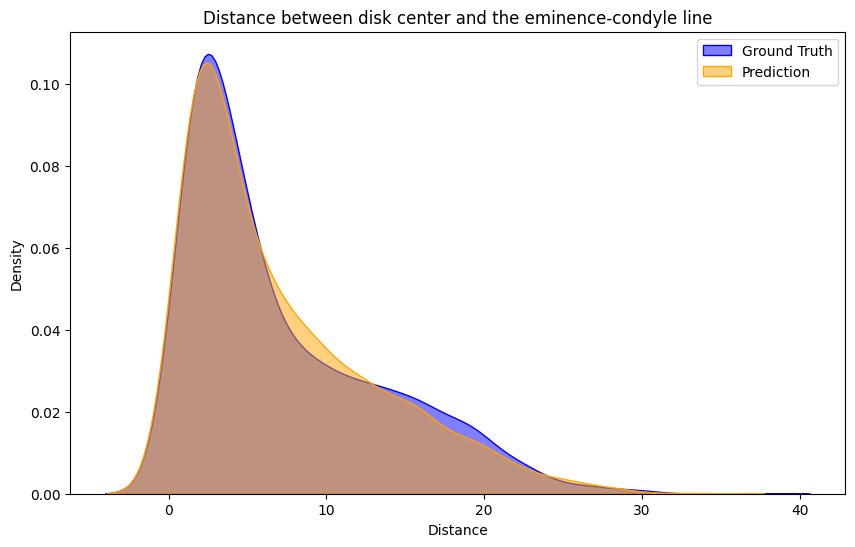

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt


# Plotting with seaborn
plt.figure(figsize=(10, 6))
sns.kdeplot(gt["Distance"], label="Ground Truth", color="blue", fill=True, alpha=0.5)
sns.kdeplot(pred["Distance"], label="Prediction", color="orange", fill=True, alpha=0.5)

# Adding legend and labels
plt.legend()
plt.xlabel("Distance")
plt.ylabel("Density")
plt.title("Distance between disk center and the eminence-condyle line")

plt.savefig("history.png", dpi=300, bbox_inches='tight', transparent=True)
# Show plot
plt.show()